In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, join, Column
from astropy.stats import LombScargle
import astropy.units as u                          # We'll need this later.

from astropy.io import ascii
import glob, re, copy

from lightkurve import KeplerLightCurveFile, KeplerLightCurve
from hot_utils import *

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


### Load a hot Kepler object - an oscillating star with a putative planet as found by [Sowicka et al](http://adsabs.harvard.edu/abs/2017MNRAS.467.4663S), 2017.

Loading light curve for KIC 8197761...


/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:218: LightkurveWarning: `LightCurveFile.from_archive()` is deprecated and will be removed soon, please use `lightkurve.search_lightcurvefile()` instead.
  LightkurveWarning)


Loaded!
Running CLEAN
Subtracted 84 sine waves
Cleaned!
Correcting with CBVs...
Corrected with CBVs!
Doing Transit Search...


/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Transit search done!
Time elapsed: 85.25 s


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Done


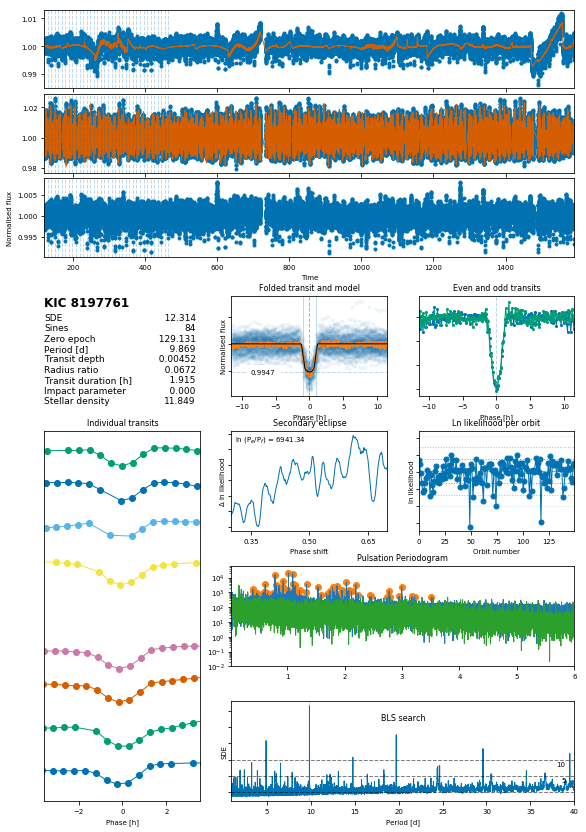

In [2]:
do_all(8197761)

Loading light curve for KIC 5613330...


/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:218: LightkurveWarning: `LightCurveFile.from_archive()` is deprecated and will be removed soon, please use `lightkurve.search_lightcurvefile()` instead.
  LightkurveWarning)


Loaded!
Running CLEAN
Subtracted 5 sine waves
Cleaned!
Correcting with CBVs...
Corrected with CBVs!
Doing Transit Search...


/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Transit search done!
Time elapsed: 62.78 s


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Done


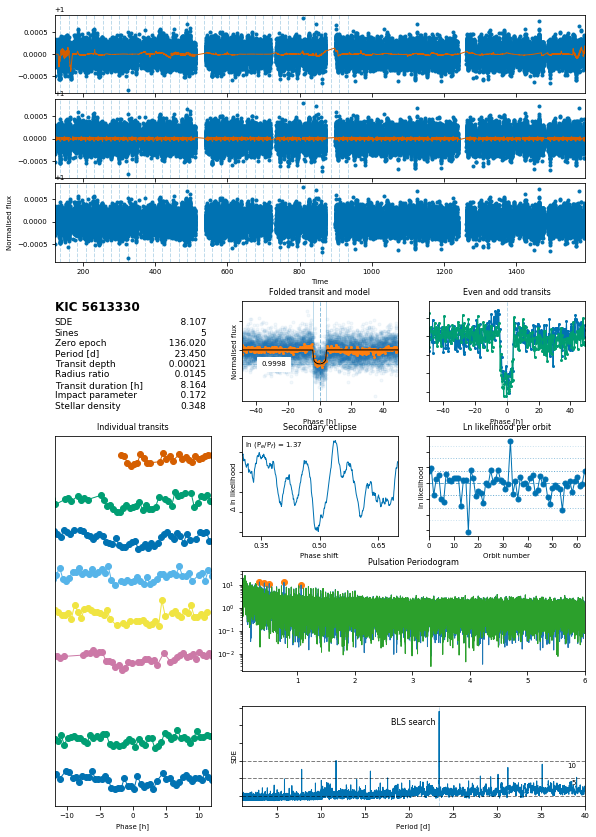

In [3]:
do_all(5613330)

In [4]:
def censor_quarters(lc):
    noisy = np.ones_like(lci.flux)
    for quarter in np.unique(lc.quarter):
        m = lc.quarter==quarter
        noisy[m] = np.nanstd(lc.flux[m])

    bad = noisy>(5*np.nanmin(noisy))
    return lc[~bad]


/anaconda3/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:218: LightkurveWarning: `LightCurveFile.from_archive()` is deprecated and will be removed soon, please use `lightkurve.search_lightcurvefile()` instead.
  LightkurveWarning)


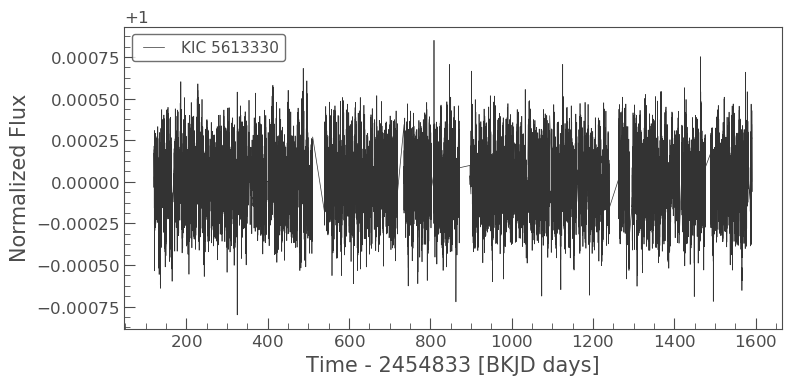

In [5]:
lcs = KeplerLightCurveFile.from_archive(5613330,cadence='long')

lc = stitch_lc_list(lcs)
lc.plot()

In [6]:
def sine_renormalize_new(lc,min_period=4./24.,max_period=30.):
    powers = []

    # get an overall mean model
    bestfreq, power, falarm = get_best_freq(lc,min_period=0.5,max_period=10)
    ytest_mean = LombScargle(lc.time, lc.flux-1, lc.flux_err).model(lc.time, bestfreq)
    current = (np.max(ytest_mean)-np.min(ytest_mean))/2.

    dummy = copy.copy(lc)

    for j, q in enumerate(np.unique(lc.quarter)):
        m = (lc.quarter == q)

        ytest = LombScargle(lc.time[m], lc.flux[m]-1., lc.flux_err[m]).model(lc.time[m], bestfreq)
        power = (np.max(ytest)-np.min(ytest))/2.#/np.median(dummy.flux[m])
        if np.abs(np.log10(power/current)) > 1:
            print('Bad quarter %d' % q)
            dummy.flux[m] = np.nan
        dummy.flux[m] = 1. + (dummy.flux[m]-1.)/(power/current)

        powers.append(power)
    
    return dummy, powers

In [7]:
lc2, powers = sine_renormalize_new(lc)


Bad quarter 10


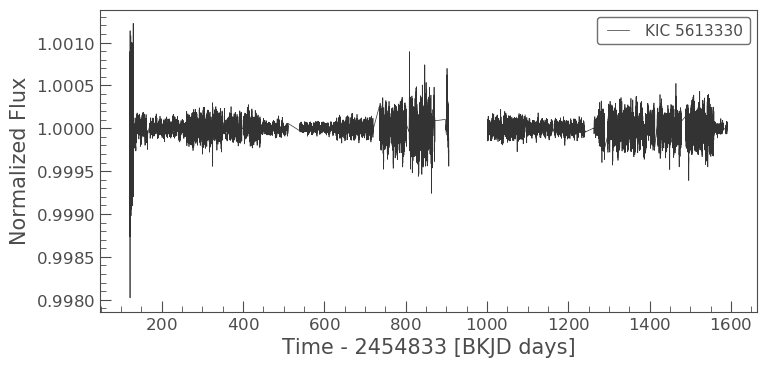

In [8]:
lc2.plot()